In [50]:
import numpy as np
import pandas as pd

df_prices=pd.read_csv("../dataset/BTC-Hourly.csv")

df_prices.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [51]:
drop_colums=['unix','symbol']
df_prices.drop(columns=drop_colums, inplace=True)

df_prices.head()

,date,open,high,low,close,Volume BTC,Volume USD
0,2022-03-01 00:00:00,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,2022-02-28 23:00:00,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,2022-02-28 22:00:00,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,2022-02-28 21:00:00,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,2022-02-28 20:00:00,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [52]:
df_prices['date']=pd.to_datetime(df_prices['date'])

start_time=pd.to_datetime('2021-02-05 10:00:00')
end_time=pd.to_datetime('2021-07-30 23:00:00')

df_prices=df_prices[(df_prices['date'] >= start_time) & (df_prices['date'] <= end_time)]

df_prices = df_prices.reset_index(drop=True)

In [53]:
df_prices = df_prices.sort_values(by='date').reset_index(drop=True)
df_prices


,date,open,high,low,close,Volume BTC,Volume USD
0,2021-02-05 10:00:00,37297.06,37698.74,37208.60,37449.95,153.306192,5.741309e+06
1,2021-02-05 11:00:00,37427.27,37775.89,37427.27,37745.68,101.295697,3.823475e+06
2,2021-02-05 12:00:00,37749.62,38168.36,37595.21,37907.00,444.407083,1.684614e+07
3,2021-02-05 13:00:00,37885.00,38351.04,37828.22,38333.77,307.770178,1.179799e+07
4,2021-02-05 14:00:00,38335.74,38350.26,38020.14,38153.19,439.239904,1.675840e+07
...,...,...,...,...,...,...,...
4209,2021-07-30 19:00:00,39136.53,39901.00,39094.76,39901.00,153.993616,6.144499e+06
4210,2021-07-30 20:00:00,39909.99,41663.99,39739.00,40691.14,516.378551,2.101203e+07
4211,2021-07-30 21:00:00,40721.76,41547.07,40663.47,41246.70,361.135721,1.489566e+07
4212,2021-07-30 22:00:00,41213.84,41514.22,41011.42,41384.94,138.238985,5.721012e+06


In [54]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt


# Create price-based features
df_prices['returns'] = df_prices['close'].pct_change()
df_prices['volatility'] = df_prices['returns'].rolling(3).std()
df_prices['momentum_3'] = df_prices['close'] - df_prices['close'].shift(3)
df_prices['rolling_mean_close_3'] = df_prices['close'].rolling(3).mean()
df_prices['rolling_std_close_3'] = df_prices['close'].rolling(3).std()
df_prices['high_low_ratio'] = df_prices['high'] / df_prices['low']
df_prices['volume_btc_change'] = df_prices['Volume BTC'].pct_change()
df_prices['volume_usd_change'] = df_prices['Volume USD'].pct_change()

# Target: next day's closing price
df_prices['target'] = df_prices['close'].shift(-1)

df_prices['close_lag1'] = df_prices['close'].shift(1)
df_prices['return_lag1'] = df_prices['returns'].shift(1)
df_prices['momentum_lag1'] = df_prices['momentum_3'].shift(1)


# Drop NaNs from feature columns and target
df_prices_model = df_prices.dropna(subset=[
    'date','open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD',
    'returns', 'volatility', 'momentum_3',
    'rolling_mean_close_3', 'rolling_std_close_3',
    'high_low_ratio', 'volume_btc_change', 'volume_usd_change', 'target', 'close_lag1', 'return_lag1', 'momentum_lag1'
])


In [55]:
df_prices_model = df_prices_model.reset_index(drop=True)
df_prices_model.shape

(4209, 19)

In [56]:
features = [
    'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD',
    'returns', 'volatility', 'momentum_3',
    'rolling_mean_close_3', 'rolling_std_close_3',
    'high_low_ratio', 'volume_btc_change', 'volume_usd_change','close_lag1', 'return_lag1', 'momentum_lag1'
]

X = df_prices_model[features]
y = df_prices_model['target']

spilt_index = int(len(X) * 0.8)
X_train, X_test = X[:spilt_index], X[spilt_index:]
y_train, y_test = y[:spilt_index], y[spilt_index:]



In [57]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),
        'random_state': 42
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best MSE:", study.best_value)


[I 2025-06-14 01:13:02,737] A new study created in memory with name: no-name-ecf31a36-b489-4eb8-b7e9-dd3e01d86a4a


[I 2025-06-14 01:13:02,978] Trial 0 finished with value: 323071.9451554952 and parameters: {'n_estimators': 316, 'max_depth': 5, 'learning_rate': 0.09353004724202744, 'subsample': 0.6351031585642425, 'colsample_bytree': 0.8006633933011806, 'reg_alpha': 0.2654565436603229, 'reg_lambda': 0.9444125170398565, 'early_stopping_rounds': 20}. Best is trial 0 with value: 323071.9451554952.
[I 2025-06-14 01:13:03,234] Trial 1 finished with value: 380500.67338108 and parameters: {'n_estimators': 147, 'max_depth': 4, 'learning_rate': 0.07693306173849532, 'subsample': 0.868624409023475, 'colsample_bytree': 0.7129793261557738, 'reg_alpha': 4.971417524462666, 'reg_lambda': 2.719142113640474, 'early_stopping_rounds': 28}. Best is trial 0 with value: 323071.9451554952.
[I 2025-06-14 01:13:03,656] Trial 2 finished with value: 544722.722941033 and parameters: {'n_estimators': 445, 'max_depth': 5, 'learning_rate': 0.07579788359910712, 'subsample': 0.875606624864222, 'colsample_bytree': 0.6228746021229328,

Best Parameters: {'n_estimators': 415, 'max_depth': 4, 'learning_rate': 0.059608286956749426, 'subsample': 0.9185165342456768, 'colsample_bytree': 0.7655236259512866, 'reg_alpha': 0.7594170992243454, 'reg_lambda': 0.4016064055184372, 'early_stopping_rounds': 42}
Best MSE: 218250.12254720862


In [58]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train final model
best_params = study.best_params
final_model = XGBRegressor(**best_params)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# Predict
y_pred_test = final_model.predict(X_test)
y_pred_train = final_model.predict(X_train)

# Metrics
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"Test MSE: {mse_test}, MAE: {mae_test}")

mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f"Train MSE: {mse_train}, MAE: {mae_train}")

rmse_train= np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
print(f"Train RMSE: {rmse_train}, Test RMSE: {rmse_test}")



[0]	validation_0-rmse:14429.62726
[1]	validation_0-rmse:13595.89790
[2]	validation_0-rmse:12810.39253
[3]	validation_0-rmse:12071.53309
[4]	validation_0-rmse:11379.89560
[5]	validation_0-rmse:10725.96123
[6]	validation_0-rmse:10111.13581
[7]	validation_0-rmse:9530.66357
[8]	validation_0-rmse:8984.60957
[9]	validation_0-rmse:8475.07446
[10]	validation_0-rmse:7997.23532
[11]	validation_0-rmse:7541.69762
[12]	validation_0-rmse:7121.89241
[13]	validation_0-rmse:6724.38817
[14]	validation_0-rmse:6347.97269
[15]	validation_0-rmse:5992.70345
[16]	validation_0-rmse:5656.62052
[17]	validation_0-rmse:5344.99153
[18]	validation_0-rmse:5048.99001
[19]	validation_0-rmse:4772.73016
[20]	validation_0-rmse:4514.92920
[21]	validation_0-rmse:4259.21224
[22]	validation_0-rmse:4028.94354
[23]	validation_0-rmse:3802.03438
[24]	validation_0-rmse:3599.12064
[25]	validation_0-rmse:3403.99678
[26]	validation_0-rmse:3222.67594
[27]	validation_0-rmse:3045.42709
[28]	validation_0-rmse:2877.71361
[29]	validation_0

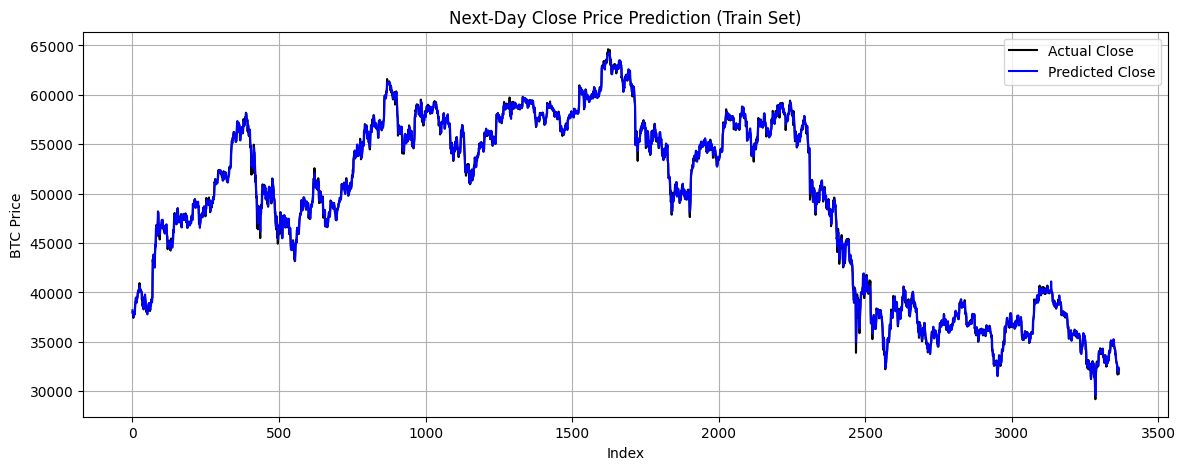

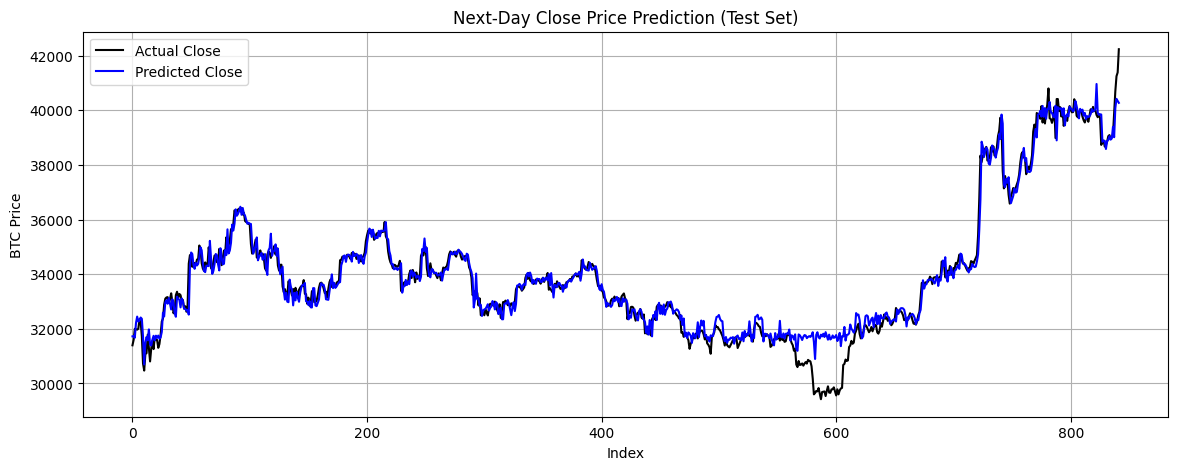

In [59]:
import matplotlib.pyplot as plt

# ----- Train Set Plot -----
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_train)), y_train, label='Actual Close', color='black')
plt.plot(range(len(y_train)), y_pred_train, label='Predicted Close', color='blue')
plt.title('Next-Day Close Price Prediction (Train Set)')
plt.xlabel('Index')
plt.ylabel('BTC Price')
plt.legend()
plt.grid(True)
plt.show()

# ----- Test Set Plot -----
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Close', color='black')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Close', color='blue')
plt.title('Next-Day Close Price Prediction (Test Set)')
plt.xlabel('Index')
plt.ylabel('BTC Price')
plt.legend()
plt.grid(True)
plt.show()


## Comparing the Price Prediction results and sentiment results

In [60]:
df_prices_model['predicted_close'] = final_model.predict(X)

In [61]:
df_prices_model['delta'] = (df_prices_model['predicted_close'] - df_prices_model['close']) / df_prices_model['close']

# Set threshold (e.g., 0.003 for 0.3%)
threshold = 0.003

df_prices_model['price_signal'] = 0  # Hold
df_prices_model.loc[df_prices_model['delta'] > threshold, 'price_signal'] = 1  # Buy
df_prices_model.loc[df_prices_model['delta'] < -threshold, 'price_signal'] = 2  # Sell


In [62]:
df_prices_model['price_signal'].value_counts()

price_signal
0    2843
1     742
2     624
Name: count, dtype: int64

In [63]:
df_sentiment=pd.read_csv('../dataset/hourly_avg_sentiment.csv')
df_sentiment

,hour,avg_sentiment,sentiment_volatility,tweet_volume,count_neg,count_neu,count_pos
0,2021-02-05 10:00:00,0.232025,0.287001,11,0.000000,0.727273,0.272727
1,2021-02-05 11:00:00,0.119410,0.543480,88,0.147727,0.556818,0.295455
2,2021-02-05 12:00:00,0.280681,0.535522,139,0.122302,0.460432,0.417266
3,2021-02-05 13:00:00,0.200531,0.488745,131,0.137405,0.534351,0.328244
4,2021-02-05 14:00:00,0.235959,0.504811,160,0.093750,0.537500,0.368750
...,...,...,...,...,...,...,...
1249,2021-07-30 19:00:00,0.362750,0.544540,1580,0.118354,0.381013,0.500633
1250,2021-07-30 20:00:00,0.314065,0.545580,2246,0.121549,0.437667,0.440784
1251,2021-07-30 21:00:00,0.292241,0.544589,2360,0.130508,0.438559,0.430932
1252,2021-07-30 22:00:00,0.360520,0.568008,1688,0.121445,0.377370,0.501185


In [64]:
df_sentiment.drop(
    columns=['sentiment_volatility','tweet_volume','count_neg','count_neu','count_pos'], inplace=True
    )

In [65]:
# Map sentiment to trade signal (optional logic)
# Feel free to improve this mapping
df_sentiment['sentiment_signal'] = 0  # Hold
df_sentiment.loc[df_sentiment['avg_sentiment'] > 0.1, 'sentiment_signal'] = 1  # Buy
df_sentiment.loc[df_sentiment['avg_sentiment'] < -0.1, 'sentiment_signal'] = 2  # Sell


In [66]:
df_sentiment.shape

(1254, 3)

In [67]:
# Ensure datetime format
df_prices_model['date'] = pd.to_datetime(df_prices_model['date'])
df_sentiment['hour'] = pd.to_datetime(df_sentiment['hour'])

# Set datetime index
df_prices_model = df_prices_model.set_index('date')
df_sentiment = df_sentiment.set_index('hour')

# Keep only relevant columns
df_prices_signal = df_prices_model[['price_signal']].copy()
df_sentiment_signal = df_sentiment[['sentiment_signal']].copy()

# Get only common timestamps (i.e., where sentiment is available)
common_index = df_sentiment_signal.index.intersection(df_prices_signal.index)

# Filter both DataFrames
df_prices_signal = df_prices_signal.loc[common_index]
df_sentiment_signal = df_sentiment_signal.loc[common_index]

# Merge
df_signals = pd.concat([df_prices_signal, df_sentiment_signal], axis=1)

# Optional: reset index
df_signals = df_signals.reset_index().rename(columns={'index': 'timestamp'})

# Output
print(df_signals.head())
print(f"Merged signal DataFrame shape: {df_signals.shape}")


            timestamp  price_signal  sentiment_signal
0 2021-02-05 14:00:00             0                 1
1 2021-02-05 15:00:00             0                 0
2 2021-02-05 16:00:00             0                 1
3 2021-02-05 17:00:00             2                 1
4 2021-02-05 18:00:00             1                 1
Merged signal DataFrame shape: (1249, 3)


In [68]:
agreement = (df_signals['price_signal'] == df_signals['sentiment_signal']).sum()
total = len(df_signals)
agreement_rate = agreement / total

print(f"Agreement Rate: {agreement_rate:.2%}")


Agreement Rate: 24.98%


<Axes: xlabel='timestamp'>

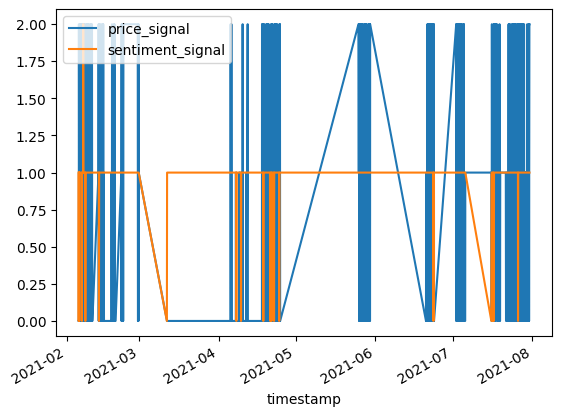

In [70]:
df_signals[['timestamp', 'price_signal', 'sentiment_signal']].set_index('timestamp').plot()
